# Detecção de câncer de mama em imagens médicas

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("forderation/breakhis-400x")

print("Path to dataset files:", path)

100%|██████████| 803M/803M [00:08<00:00, 94.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/forderation/breakhis-400x/versions/1


Importando as bibliotecas que serão usadas

In [2]:
import os
import numpy as np
import pandas as pd
import pickle
import cv2
import tensorflow as tf
from google.colab import files, drive
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50V2
import pytest
drive.mount('/content/drive')

Mounted at /content/drive


Montagem dos dataframes de treino e de teste

In [3]:
base_path = os.path.join(path, "BreaKHis 400X")

def build_df(base_path, split):
    filepaths = []
    labels = []
    for cls in ['benign', 'malignant']:
        folder = os.path.join(base_path, split, cls)
        for f in os.listdir(folder):
            if f.endswith(".png") or f.endswith(".jpg"):
                filepaths.append(os.path.join(split, cls, f))
                labels.append(0 if cls=='benign' else 1)
    return pd.DataFrame({'filepath': filepaths, 'label': labels})

train_df = build_df(base_path, "train")
test_df   = build_df(base_path, "test")


In [4]:
train_df.head()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1148 entries, 0 to 1147
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  1148 non-null   object
 1   label     1148 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.1+ KB


In [5]:
test_df.head()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  545 non-null    object
 1   label     545 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.6+ KB


In [6]:
print("Treino:")
print(train_df['label'].value_counts())
print(train_df['label'].value_counts(normalize=True))

print("\nTeste:")
print(test_df['label'].value_counts())
print(test_df['label'].value_counts(normalize=True))

Treino:
label
1    777
0    371
Name: count, dtype: int64
label
1    0.676829
0    0.323171
Name: proportion, dtype: float64

Teste:
label
1    369
0    176
Name: count, dtype: int64
label
1    0.677064
0    0.322936
Name: proportion, dtype: float64


Distribuição das classes nos dois conjuntos, nota-se um desbalanceamento nos dados, tanto no conjunto de treino e de teste. Cerca de 68% dos dados são de imagens com tumores malignos e 32% para imagens de tumores benignos.

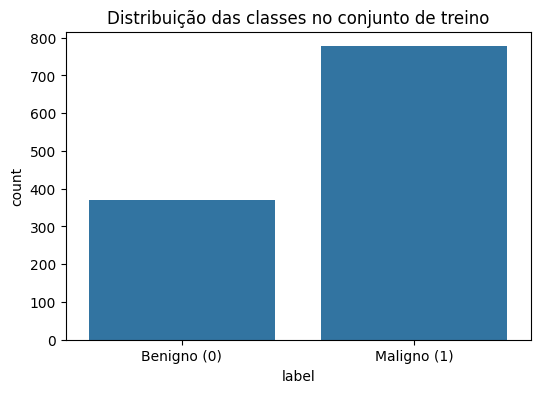

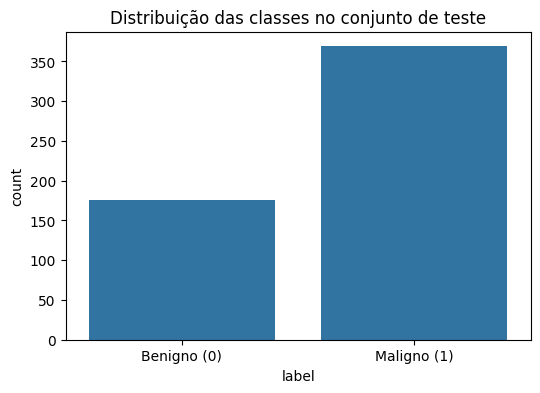

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=train_df)
plt.title("Distribuição das classes no conjunto de treino")
plt.xticks([0,1], ["Benigno (0)", "Maligno (1)"])
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='label', data=test_df)
plt.title("Distribuição das classes no conjunto de teste")
plt.xticks([0,1], ["Benigno (0)", "Maligno (1)"])
plt.show()

## Geração das imagens para treino e teste.

Aqui, definimos o formato de geração das imagens do treino. Estamos aplicado normalização e data augmentation para evitar overfitting:
- **rescale=1./255** -> normaliza os valores dos pixels
- **rotation_range=15** -> permite rotações aleatórias das imagens em até 15 graus
- **width_shift_range=0.2** -> desloca horizontalmente a imagem em até 20% da largura de sua largura.
- **height_shift_range=0.2** -> semelhante ao anterior, mas agora na vertical.
- **shear_range=0.2** -> aplica um corte inclinado de até 20%.
- **zoom_range=0.2** -> aplica zoom in/out (aproxima/afasta) aleatoriamente de até 20% da imagem.
- **horizontal_flip=True** -> permite inverter a imagem horizontalmente.
- **vertical_flip=True** -> semelhante ao anterior, mas agora na vertical.
- **fill_mode='nearest'** -> se houver corte, a imagem é preenchida com os valores próximos aos da borda.

Isso permite que, durante o treino, o modelo possa generalizar melhor, sem decorar os pixels da imagem, e sim aprender padrões relevantes para diagnóstico.

Na geração das imagens de teste, só aplica-se a normalização, permitindo medir o desempenho real do modelo sem distorção nas imagens.



In [8]:
train_dir = f"{base_path}/train"
test_dir  = f"{base_path}/test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 36

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

Agora, há a aplicação das regras de geração das imagens definidas anteriormente:
- **target_size=IMG_SIZE** -> Redimensiona todas as imagens para 224x224.
- **batch_size=BATCH_SIZE** -> Define quantas imagens serão geradas por batch.
- **class_mode='categorical'** -> Gera um vetor one-hot para classificação entre benigno e maligno.
- **shuffle** -> Na geração para treino, aplica-se o embaralhamento para evitar que o modelo decore a sequência das imagens, já no teste, isso não é ncessário.



In [9]:
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1148 images belonging to 2 classes.
Found 545 images belonging to 2 classes.


Visualização de algumas imagens já geradas pelo ImageDataGenerator:

In [10]:
def show_images(generator, df, img_size=(224,224), batch_size=BATCH_SIZE, n_show=12):

    imgs, labels = next(generator)
    plt.figure(figsize=(15, 8))

    for i in range(n_show):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(imgs[i])
        plt.title(f"Label: {np.argmax(labels[i])}")
        plt.axis("off")

    plt.show()

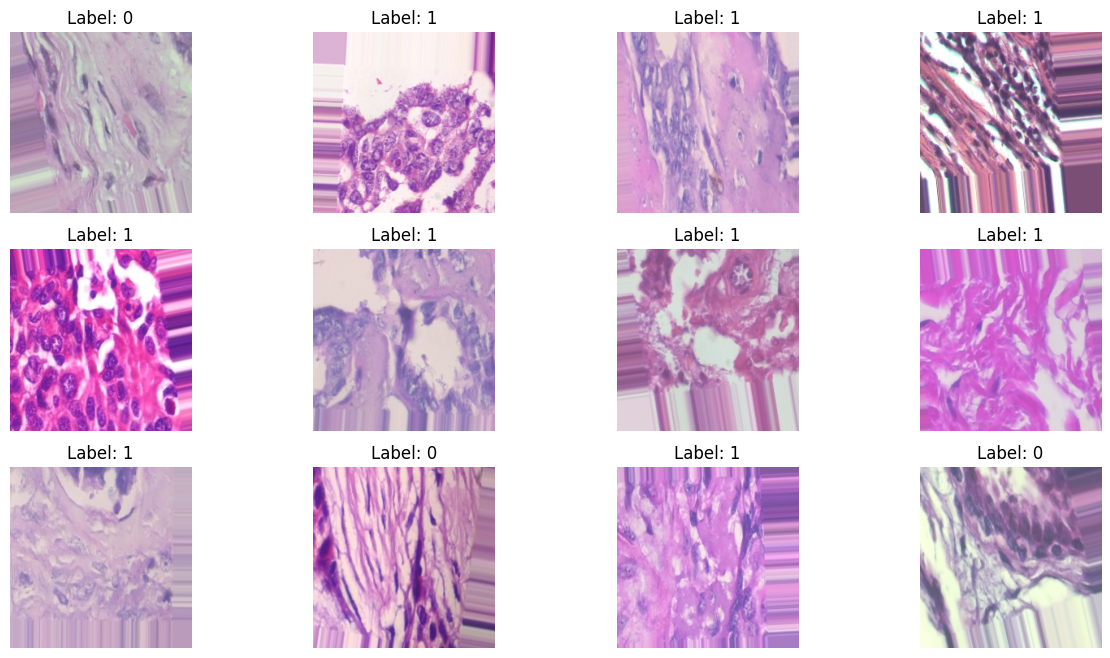

In [11]:
show_images(train_gen, train_df, n_show=12)

## Sobre ResNetV2

A ResNetV2 foi proposto em 2016 no artigo "**Identify Mappings in Deep Residual Networks (Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun)**" como uma evolução da ResNetV1, proposto em 2015, e nasce como uma tentativa de entender mais a fundo o porque que a ResNetV1 funcionava e como poderia melhorá-la ainda mais.

Na primeira versão da ResNet, foi-se introduzido o conceito de blocos residuais e skip connections que permitiam o treinamento de redes profundas.

### Mas o que são blocos residuais e skip connections?

Antes da ResNet, acreditava-se que empilhar camadas e mais camadas em uma rede neural sempre levaria a uma melhoria de desempenho. Porém, na prática, notou-se que:
- Redes muito profundas tinham uma menor precisão nos conjuntos de teste e treino em comparação com redes mais rasas;
- Isso não era um problema de overfitting, pois a rede não conseguia aprender nem os dados de treino, e sim de otimização: não era possível treinar de forma eficiente essas redes devido ao **exploding gradient** (explosão dos gradientes durante o backpropagation).

Assim, nascem os blocos residuais com uma solução para esse problema: a **skip connection**. Ela permite que a informação importante pule algumas camadas, auxiliando para que a rede não se perca e possa aprender de forma mais eficiente.

### O que mudou da primeira versão para a segunda?

Acreditava-se que a ResNetV1 funcionava muito bem devido aos caminhos diretos que as skip connections criavam para o fluxo da informação, porém, durante a análise da prmeira versão, notou-se que sua arquitetura na verdade atrapalhava o fluxo ideal da informação:
- Na ResNetV1 (a), as operações de **normalização(BatchNorm)** e **ativação(ReLU)** estavam no caminho principal;
- Quando o gradiente retropropagava, passava pela função residual e pelo caminho skip, porém, ele era modificado por uma operação ReLU após a adição.

Essas operações acabavam sendo obstáculos para o fluxo livre da informação, principalmente ao tratar de redes com mais de 1000 camadas.

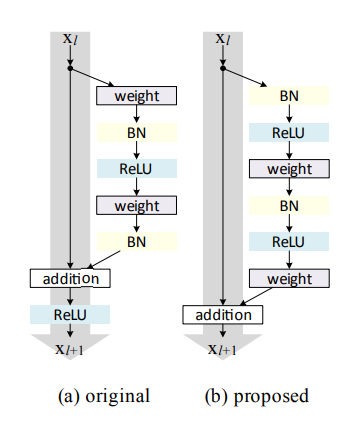

Assim, nasce a ideia que deu origem ao artigo da ResNetV2 (b): reorganizar a ordem das operações para conseguir liberar o skip connection de qualquer obstáculo, ou seja, mover todas as operações de normalização e ativação para antes das convoluções, e a isso se deu o nome de **Pré-Ativação**.

Assim, a ResNetV2 mostrou-se como um refinamento da versão original, com a melhora do fluxo da informação através da pré-ativação.

## Modelo

No modelo, decidimos utilizar uma rede pré-treinada, já que o dataset é pequeno.

Escolhemos então o ResNet50V2, pois ele utiliza no seu treinamento imagens do ImageNet, aprendendo features genéricas, como bordas e texturas que tendem a funcionar bem em imagens médicas. Além disso, é uma rede forte contra o desvanecimendo do gradiente, graças aos blocos residuais, permitindo treinar redes profundas mesmo com datasets pequenos.

1- Ignoramos as camadas densas de classificação da rede pré-treinada, já que só queremos o extrator de características.

2- Congelamos a base, impedindo que os pesos do modelo pré-treinado sejam atualizados inicialmente, já que sabemos que ele já aprendeu features importantes, permitindo que o modelo aprenda apenas as camadas finais adaptadas ao nosso problema.

3- Reduzimos o mapa de features 3D para um vetor 1D, à fim de evitar overfitting.

4- Criamos uma camada totalmente conectada de 512 neurônios, que permite ao modelo combinar as características que já foram aprendidas na base em padrões específicos do nosso problema.

5- Desligamos 50% dos neurônios de forma aleatória durante o treino, evitando que a rede memorize imagens.

6- Camada final com duas saídas.

In [12]:
# 1
base_model = ResNet50V2(include_top=False, input_shape=(*IMG_SIZE, 3), weights='imagenet')

# 2
base_model.trainable = False

# 3
x = GlobalAveragePooling2D()(base_model.output)

# 4
x = Dense(512, activation='relu')(x)

# 5
x = Dropout(0.5)(x)

# 6
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# for layer in base_model.layers:
#     layer.trainable = False

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Para o treinamento, escolhemos as seguintes configurações:
- **optimizer=Adam(learning_rate=1e-4)** -> Taxa de aprendizado para cada peso nem tão alta, para evitar oscilação, nem tão baixa, para aumentar a velocidade do treinamento.
- **loss='caregorical_crossentropy'** -> Mede a diferença entre a distribuição real e a prevista dos dados.
- **metrics=['accuracy', tf.keras.metrics.AUC()]** -> Usadas pra monitorar o desempenho durante o treino.

In [13]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

Alguns callbacks se fazem necessário, tanto pra evitar overfitting quanto pra economizar tempo de treinamento:
- **EarlyStopping** -> Usado para interromper o treinamento antes de completar todas as épocas;
  - **patience=5** -> Espera 5 épocas sem melhora antes de parar;
  - **restore_best_weights=True** -> Após a parada, volta com os pesos da melhor época;
  - **monitor='val_loss'** -> Verifica a perda na validação para a decisão de parada;
  - **mode='min'** -> Quanto menor o valor do val_loss, melhor;
  - **min_delta=0.001** -> A melhora só é considerada se a perda cair pelo menos 0.001.
- **ReduceLROnPlateau** -> Maneira de reduzir a taxa de aprendizado durante o treinamento quando o modelo estagnar.
  - **factor=0.1** -> Ao notar a estagnação, multiplica o  learning rate por 0.1;
  - **patience=3** -> Espera 3 épocas sem melhora antes de reduzir;
  - **monitor=val_loss** -> Como no EarlyStopping, utiliza o val_loss para decidir se reduz a taxa de aprendizado;
  - **mode='min'** -> O mesmo que para o EarlyStopping.

In [14]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss', mode='min', min_delta=0.001),
    ReduceLROnPlateau(factor=0.1, patience=3, monitor='val_loss', mode='min')
]

Finalmente, chegamos na etapa de iniciação ao treinamento e todas as configurações definidas anteriomente serão usadas.

In [15]:
history = model.fit(
    train_gen,
    epochs=60,
    validation_data=test_gen,
    callbacks=callbacks
)

model.save('modelo.h5')
files.download('modelo.h5')

with open("history.pkl", "wb") as f:
    pickle.dump(history.history, f)

files.download("history.pkl")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.6225 - auc: 0.6527 - loss: 0.7579 - val_accuracy: 0.7339 - val_auc: 0.8078 - val_loss: 0.5400 - learning_rate: 1.0000e-04
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.7224 - auc: 0.8072 - loss: 0.5549 - val_accuracy: 0.7633 - val_auc: 0.8369 - val_loss: 0.5049 - learning_rate: 1.0000e-04
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7579 - auc: 0.8409 - loss: 0.4972 - val_accuracy: 0.7780 - val_auc: 0.8504 - val_loss: 0.4869 - learning_rate: 1.0000e-04
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.7761 - auc: 0.8442 - loss: 0.4936 - val_accuracy: 0.7945 - val_auc: 0.8683 - val_loss: 0.4584 - learning_rate: 1.0000e-04
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.7982 - auc: 0.8696 - loss: 0.4584 - val_accuracy: 0.7835 - val_auc: 0.8717 - val_loss: 0.4511 - learning_rate: 1.0000e-04
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8046 -

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

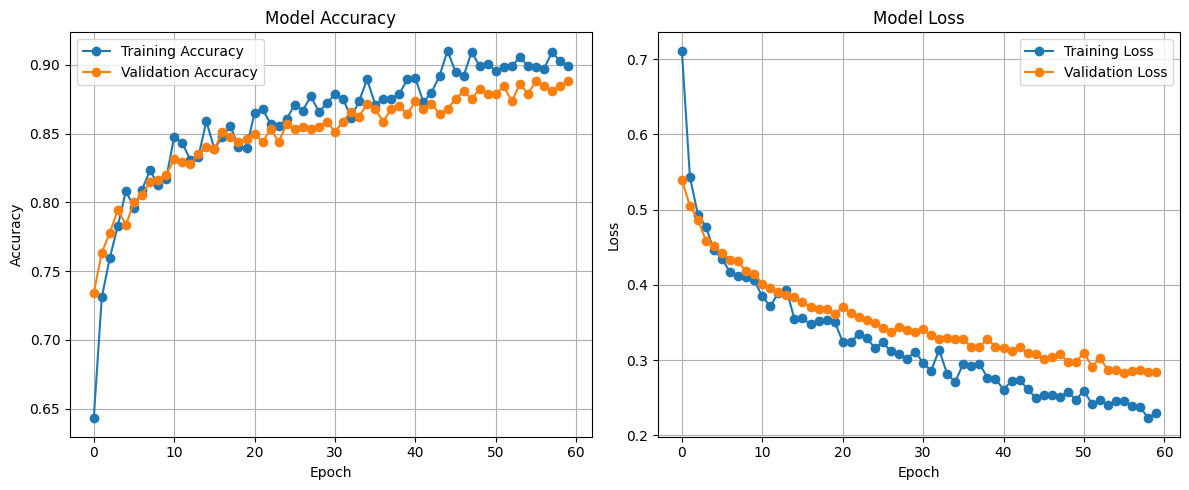

In [17]:
# history =
plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

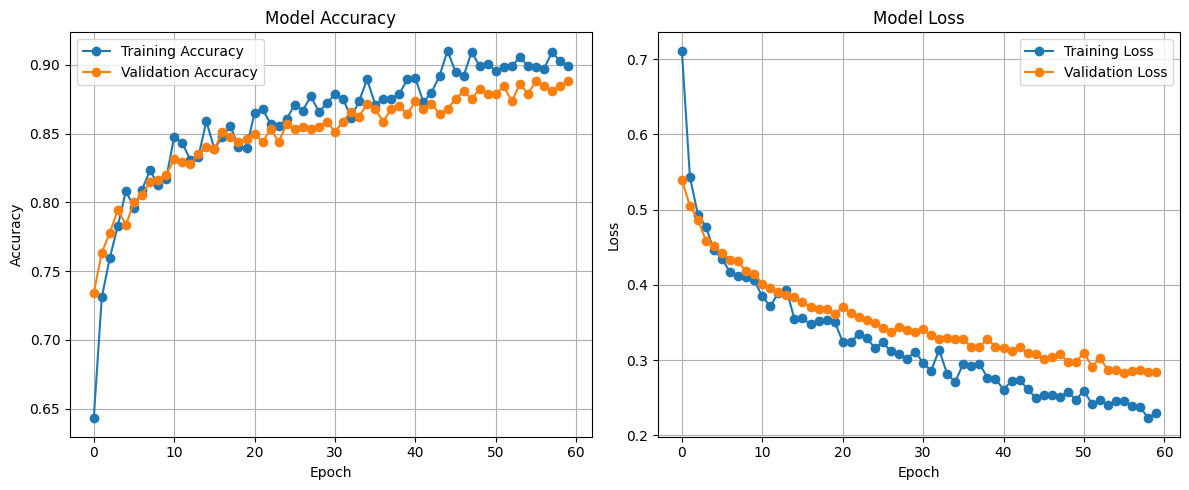

In [19]:
with open('/content/drive/MyDrive/Projeto_Mamografia/history.pkl', 'rb') as f:
    history2 = pickle.load(f)
model = load_model('/content/drive/MyDrive/Projeto_Mamografia/modelo.h5')

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history2['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history2['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history2['loss'], label='Training Loss', marker='o')
plt.plot(history2['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [20]:
!pip install -q kaggle
!rm -rf ~/.kaggle
!mkdir -p ~/.kaggle

Necessário gerar um kaggle.json no site do Kaggle

1. Clica na sua foto de perfil do Kaggle
2. Clica em Settings
3. Vai na parte de API
4. Clica em Create New Token

Ao rodar o código abaixo, insira o token gerado

In [21]:
!pip install kaggle --quiet

import os
import pandas as pd
from PIL import Image
import numpy as np
from google.colab import files

files.upload()

!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d ambarish/breakhis

!unzip -q breakhis.zip -d breakhis

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/ambarish/breakhis
License(s): unknown
 98% 3.92G/3.99G [00:49<00:05, 12.9MB/s]
100% 3.99G/3.99G [00:49<00:00, 85.7MB/s]


In [22]:
import os
import pandas as pd
from pathlib import Path

image_paths = []
labels = []
magnifications = []

base_path = "breakhis/BreaKHis_v1"
for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            full_path = os.path.join(root, file)
            image_paths.append(full_path)

            parts = Path(full_path).parts
            if 'benign' in parts:
                labels.append('benign')
            elif 'malignant' in parts:
                labels.append('malignant')
            else:
                labels.append('unknown')

            mag = file.split('-')[-2]
            magnifications.append(mag)

df_corrected = pd.DataFrame({
    'path': image_paths,
    'label': labels,
    'magnification': magnifications
})

print("═" * 50)
print("✅ DATAFRAME CORRETO CRIADO")
print("═" * 50)
print(f"Total de imagens: {len(df_corrected)}")
print(f"Distribuição por classe:")
print(df_corrected['label'].value_counts())
print(f"\nDistribuição por aumento:")
print(df_corrected['magnification'].value_counts())
print(f"\nPrimeiras entradas:")
print(df_corrected.head())

══════════════════════════════════════════════════
✅ DATAFRAME CORRETO CRIADO
══════════════════════════════════════════════════
Total de imagens: 7909
Distribuição por classe:
label
malignant    5429
benign       2480
Name: count, dtype: int64

Distribuição por aumento:
magnification
100    2081
200    2013
40     1995
400    1820
Name: count, dtype: int64

Primeiras entradas:
                                                path   label magnification
0  breakhis/BreaKHis_v1/BreaKHis_v1/histology_sli...  benign            40
1  breakhis/BreaKHis_v1/BreaKHis_v1/histology_sli...  benign            40
2  breakhis/BreaKHis_v1/BreaKHis_v1/histology_sli...  benign            40
3  breakhis/BreaKHis_v1/BreaKHis_v1/histology_sli...  benign            40
4  breakhis/BreaKHis_v1/BreaKHis_v1/histology_sli...  benign            40


Expansão do dataset para imagens em 200x e 400x

In [23]:
df_200_400 = df_corrected[df_corrected['magnification'].isin(['200', '400'])].copy()

print("═" * 50)
print("🎯 DATASET FILTRADO - 200X + 400X")
print("═" * 50)
print(f"Total de imagens: {len(df_200_400)}")
print(f"Redução: {100 - (len(df_200_400)/len(df_corrected)*100):.1f}%")

print(f"\nDistribuição por classe:")
print(df_200_400['label'].value_counts())
print(f"\nDistribuição por aumento:")
print(df_200_400['magnification'].value_counts())

df_200_400['label_int'] = df_200_400['label'].map({'benign': 0, 'malignant': 1})

══════════════════════════════════════════════════
🎯 DATASET FILTRADO - 200X + 400X
══════════════════════════════════════════════════
Total de imagens: 3833
Redução: 51.5%

Distribuição por classe:
label
malignant    2622
benign       1211
Name: count, dtype: int64

Distribuição por aumento:
magnification
200    2013
400    1820
Name: count, dtype: int64


In [24]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    df_200_400,
    test_size=0.2,
    random_state=42,
    stratify=df_200_400['label']
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df['label']
)

print(f"Treino: {len(train_df)} imagens")
print(f"Validação: {len(val_df)} imagens")
print(f"Teste: {len(test_df)} imagens")

Treino: 3066 imagens
Validação: 383 imagens
Teste: 384 imagens


In [25]:
train_df.head()

,path,label,magnification,label_int
5377,breakhis/BreaKHis_v1/BreaKHis_v1/histology_sli...,malignant,400,1
4737,breakhis/BreaKHis_v1/BreaKHis_v1/histology_sli...,malignant,200,1
7836,breakhis/BreaKHis_v1/BreaKHis_v1/histology_sli...,malignant,200,1
1509,breakhis/BreaKHis_v1/BreaKHis_v1/histology_sli...,benign,200,0
1905,breakhis/BreaKHis_v1/BreaKHis_v1/histology_sli...,benign,400,0


Divisão em treino, validação e teste

In [26]:
print('Training set')
print(train_df.label.value_counts())

print('\nValidation set')
print(val_df.label.value_counts())

print('\nTest set')
print(test_df.label.value_counts())

Training set
label
malignant    2097
benign        969
Name: count, dtype: int64

Validation set
label
malignant    262
benign       121
Name: count, dtype: int64

Test set
label
malignant    263
benign       121
Name: count, dtype: int64


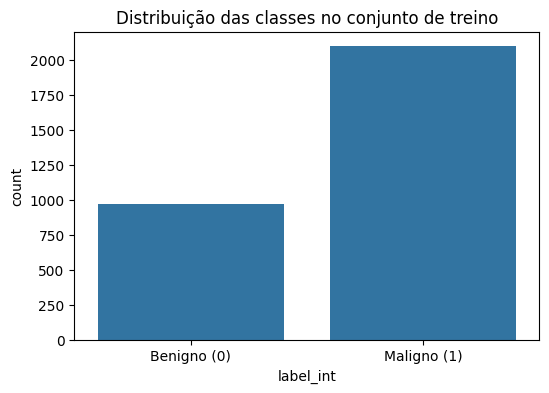

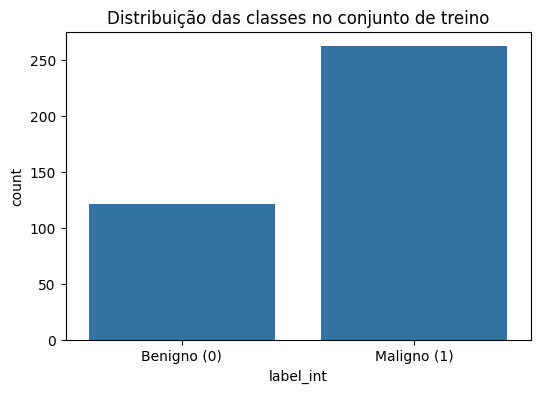

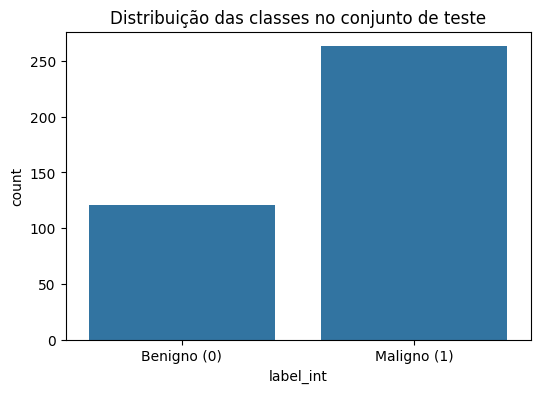

In [27]:
plt.figure(figsize=(6,4))
sns.countplot(x='label_int', data=train_df)
plt.title("Distribuição das classes no conjunto de treino")
plt.xticks([0,1], ["Benigno (0)", "Maligno (1)"])
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='label_int', data=val_df)
plt.title("Distribuição das classes no conjunto de treino")
plt.xticks([0,1], ["Benigno (0)", "Maligno (1)"])
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='label_int', data=test_df)
plt.title("Distribuição das classes no conjunto de teste")
plt.xticks([0,1], ["Benigno (0)", "Maligno (1)"])
plt.show()

Ajuste de parâmetros do ImageDataGenerator para melhor se alinhar ao problema

Notou-se que os parâmetros antigos poderiam estar prejudicando o treinamento devido à possíveis cortes em regiões que são importantes para o modelo, por isso o ajuste menos agressivo.

In [28]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 36

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [29]:
def dataframe_to_dataset(df, datagen, batch_size=32, shuffle=False, target_size=(224, 224)):
    """
    Cria um gerador de dados a partir de um DataFrame.
    """
    generator = datagen.flow_from_dataframe(
        dataframe=df,
        x_col='path',
        y_col='label_int',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='raw',
        shuffle=shuffle,
        seed=42
    )
    return generator

In [30]:
train_generator = dataframe_to_dataset(
    train_df,
    train_datagen,
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=IMG_SIZE
)

val_generator = dataframe_to_dataset(
    val_df,
    test_datagen,
    batch_size=BATCH_SIZE,
    shuffle=False,
    target_size=IMG_SIZE
)

test_generator = dataframe_to_dataset(
    test_df,
    test_datagen,
    batch_size=BATCH_SIZE,
    shuffle=False,
    target_size=IMG_SIZE
)

Found 3066 validated image filenames.
Found 383 validated image filenames.
Found 384 validated image filenames.


Verificação de um batch

In [31]:
batch_images, batch_labels = next(train_generator)

print("═" * 50)
print("📊 INFORMAÇÕES DO BATCH")
print("═" * 50)
print(f"Shape das imagens: {batch_images.shape}")
print(f"Shape dos labels: {batch_labels.shape}")
print(f"Valores dos labels: {batch_labels[:10]}")
print(f"Valores min/max das imagens: {batch_images.min():.3f}, {batch_images.max():.3f}")

unique_labels = np.unique(batch_labels)
print(f"Labels únicos no batch: {unique_labels}")

══════════════════════════════════════════════════
📊 INFORMAÇÕES DO BATCH
══════════════════════════════════════════════════
Shape das imagens: (36, 224, 224, 3)
Shape dos labels: (36,)
Valores dos labels: [1 0 1 0 1 1 0 0 1 1]
Valores min/max das imagens: 0.040, 1.000
Labels únicos no batch: [0 1]


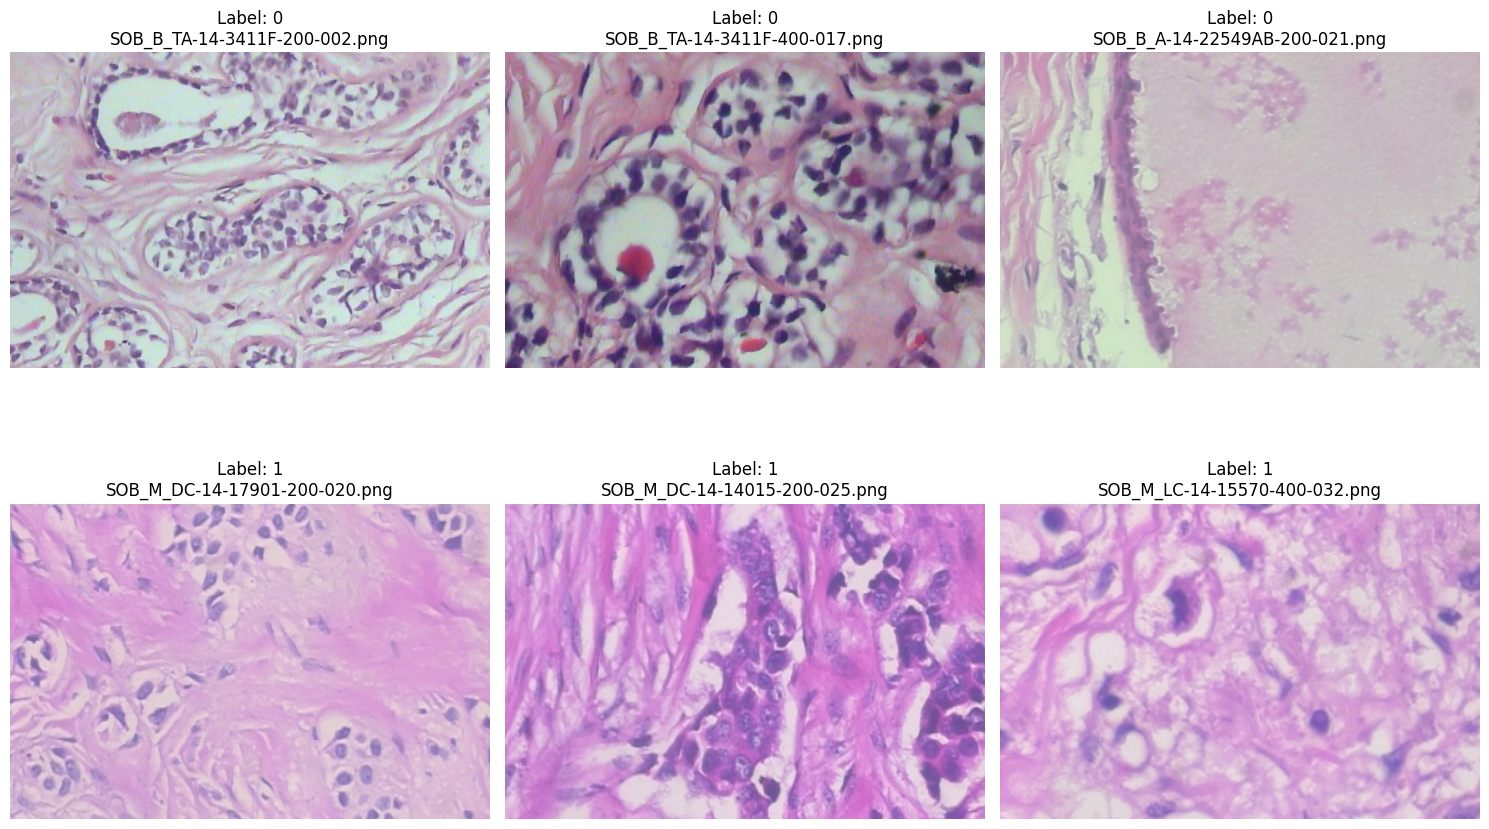

In [32]:
benign_sample = train_df[train_df['label_int'] == 0].sample(3)
malignant_sample = train_df[train_df['label_int'] == 1].sample(3)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, (idx, row) in enumerate(benign_sample.iterrows()):
    img = plt.imread(row['path'])
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Label: {row["label_int"]}\n{row["path"].split("/")[-1]}')
    axes[0, i].axis('off')

for i, (idx, row) in enumerate(malignant_sample.iterrows()):
    img = plt.imread(row['path'])
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Label: {row["label_int"]}\n{row["path"].split("/")[-1]}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

Mudança para saída sigmoid, mantido-se o modelo antigo

In [44]:
base_model2 = ResNet50V2(include_top=False, input_shape=(*IMG_SIZE, 3), weights='imagenet')

base_model2.trainable = False

y = GlobalAveragePooling2D()(base_model2.output)

y = Dense(512, activation='relu')(y)

y = Dropout(0.5)(y)

output2 = Dense(1, activation='sigmoid')(y)

model2 = Model(inputs=base_model2.input, outputs=output2)

Métricas adicionadas para acompanhar durante o treinamento

In [45]:
model2.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall', 'auc']
)

Patience diminuído, min_delta maior (Evita que o modelo fique oscilando)

In [46]:
callbacks2 = [
    EarlyStopping(patience=2, restore_best_weights=True, monitor='val_loss', mode='min', min_delta=0.01),
    ReduceLROnPlateau(factor=0.1, patience=2, monitor='val_loss', mode='min'),
]

Adicionado pesos para cada classe (1.582 para benigno, 0.731 para maligno)

In [47]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_df['label_int']),
    y=train_df['label_int']
)
class_weights = dict(enumerate(class_weights))

print(f"Class weights: {class_weights}")

Class weights: {0: np.float64(1.5820433436532508), 1: np.float64(0.7310443490701002)}


Treinamento

In [43]:
history2 = model2.fit(
    train_generator,
    epochs=60,
    validation_data=val_generator,
    callbacks=callbacks2,
    class_weight=class_weights
)

Epoch 1/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 94s 972ms/step - accuracy: 0.6281 - auc: 0.6930 - loss: 0.6428 - precision: 0.7910 - recall: 0.6080 - val_accuracy: 0.7546 - val_auc: 0.8493 - val_loss: 0.5237 - val_precision: 0.9038 - val_recall: 0.7176 - learning_rate: 1.0000e-04
Epoch 2/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 74s 862ms/step - accuracy: 0.7412 - auc: 0.8270 - loss: 0.5206 - precision: 0.8730 - recall: 0.7181 - val_accuracy: 0.7833 - val_auc: 0.8692 - val_loss: 0.4538 - val_precision: 0.8943 - val_recall: 0.7748 - learning_rate: 1.0000e-04
Epoch 3/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 73s 849ms/step - accuracy: 0.7962 - auc: 0.8678 - loss: 0.4525 - precision: 0.8886 - recall: 0.8035 - val_accuracy: 0.7781 - val_auc: 0.8832 - val_loss: 0.4507 - val_precision: 0.8933 - val_recall: 0.7672 - learning_rate: 1.0000e-04
Epoch 4/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 74s 858ms/step - accuracy: 0.8074 - auc: 0.8964 - loss: 0.4122 - precision: 0.9008 - recall: 0.8009 - val_accuracy: 0.8016 - val_auc: 0.8846 - val_lo

ImportError: cannot import name 'gfiles' from 'google.colab' (/usr/local/lib/python3.12/dist-packages/google/colab/__init__.py)

In [49]:
from google.colab import files
import time
model2.save('new_modelo.h5')
files.download('new_modelo.h5')
time.sleep(2)
import pickle

with open("new_history.pkl", "wb") as f:
    pickle.dump(history2.history, f)

files.download("new_history.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

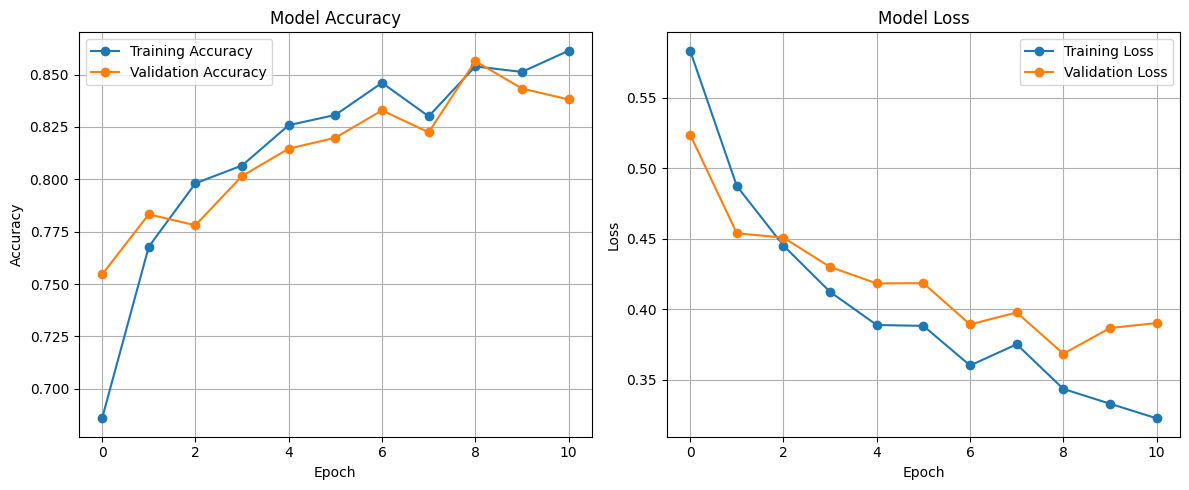

In [48]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss', marker='o')
plt.plot(history2.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

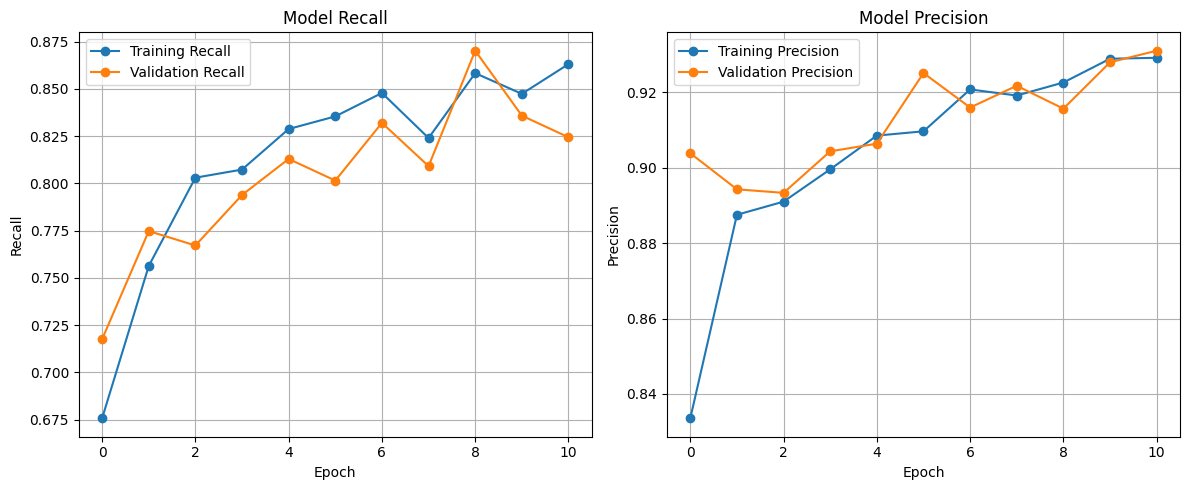

In [53]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history2.history['recall'], label='Training Recall', marker='o')
plt.plot(history2.history['val_recall'], label='Validation Recall', marker='o')
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history2.history['precision'], label='Training Precision', marker='o')
plt.plot(history2.history['val_precision'], label='Validation Precision', marker='o')
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()

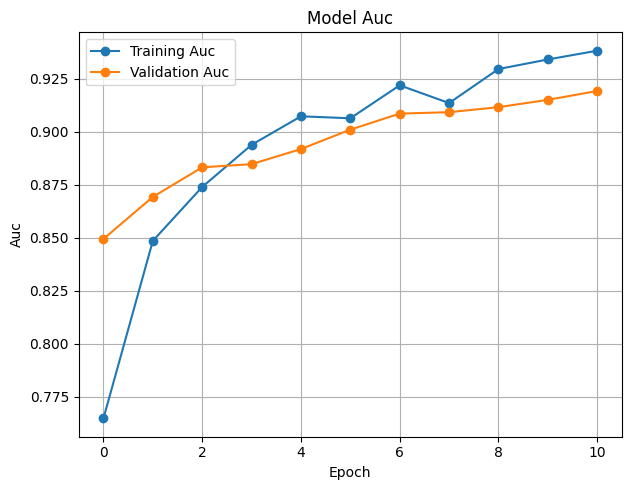

In [52]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 2)
plt.plot(history2.history['auc'], label='Training Auc', marker='o')
plt.plot(history2.history['val_auc'], label='Validation Auc', marker='o')
plt.title('Model Auc')
plt.ylabel('Auc')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()